In [9]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [85]:
data_size = 200
noise_mag = 1 # the higher the noisier

# we now open the file input_vectors.txt so that the vhd code can process it
f = open("input.txt", "w")

input_sig = []

for i in range(data_size):
    noise = np.sin(i)
    sig = 65*(np.sin(i/30)+ noise_mag*noise)
    noise = -noise
    f.write('%d\n' % sig.astype(int)) # we write it as an int
    input_sig.append(sig.astype(int)) # we write it as an int

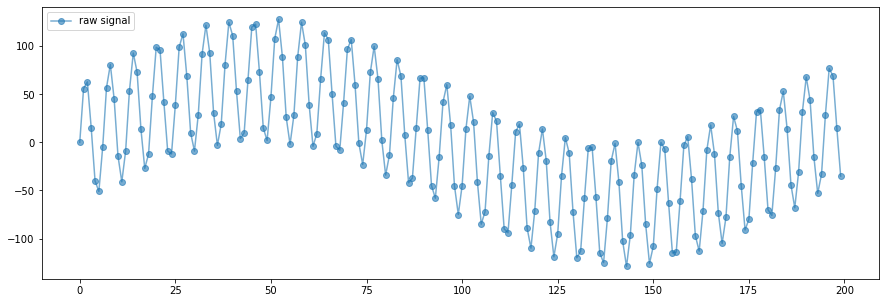

In [86]:
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [12]:
# After being computed on the actual FPGA

In [72]:
# we save the result obtained using the testbench in a array named tb
fpga = [0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,11,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,12,7,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,-5,-11,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-12,-13,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-15,-14,-10,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-4,2,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,12,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,10,6,6,6,6,6,6,6,6,6,6,6,6,6,6]
for i in range(len(fpga)):
    fpga[i] = 4*fpga[i]

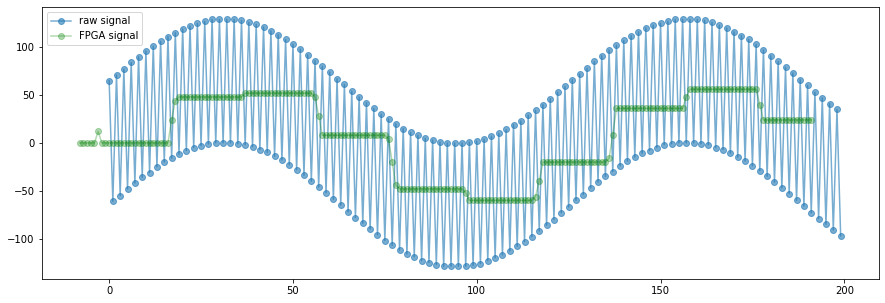

In [73]:
plt.figure(figsize=(15, 5))

t = np.arange(len(input_sig))
plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
t = np.arange(len(fpga))
plt.plot(t-8, fpga, '-o', color='g',alpha=.3,label='FPGA signal')
#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")